# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf

warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
defender_df = fm_data_df[fm_data_df['포지션']=='수비수']
defender_df = defender_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [defender_df.columns[i] for i,x in enumerate(defender_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
defender_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

## 변수 별 분포 확인

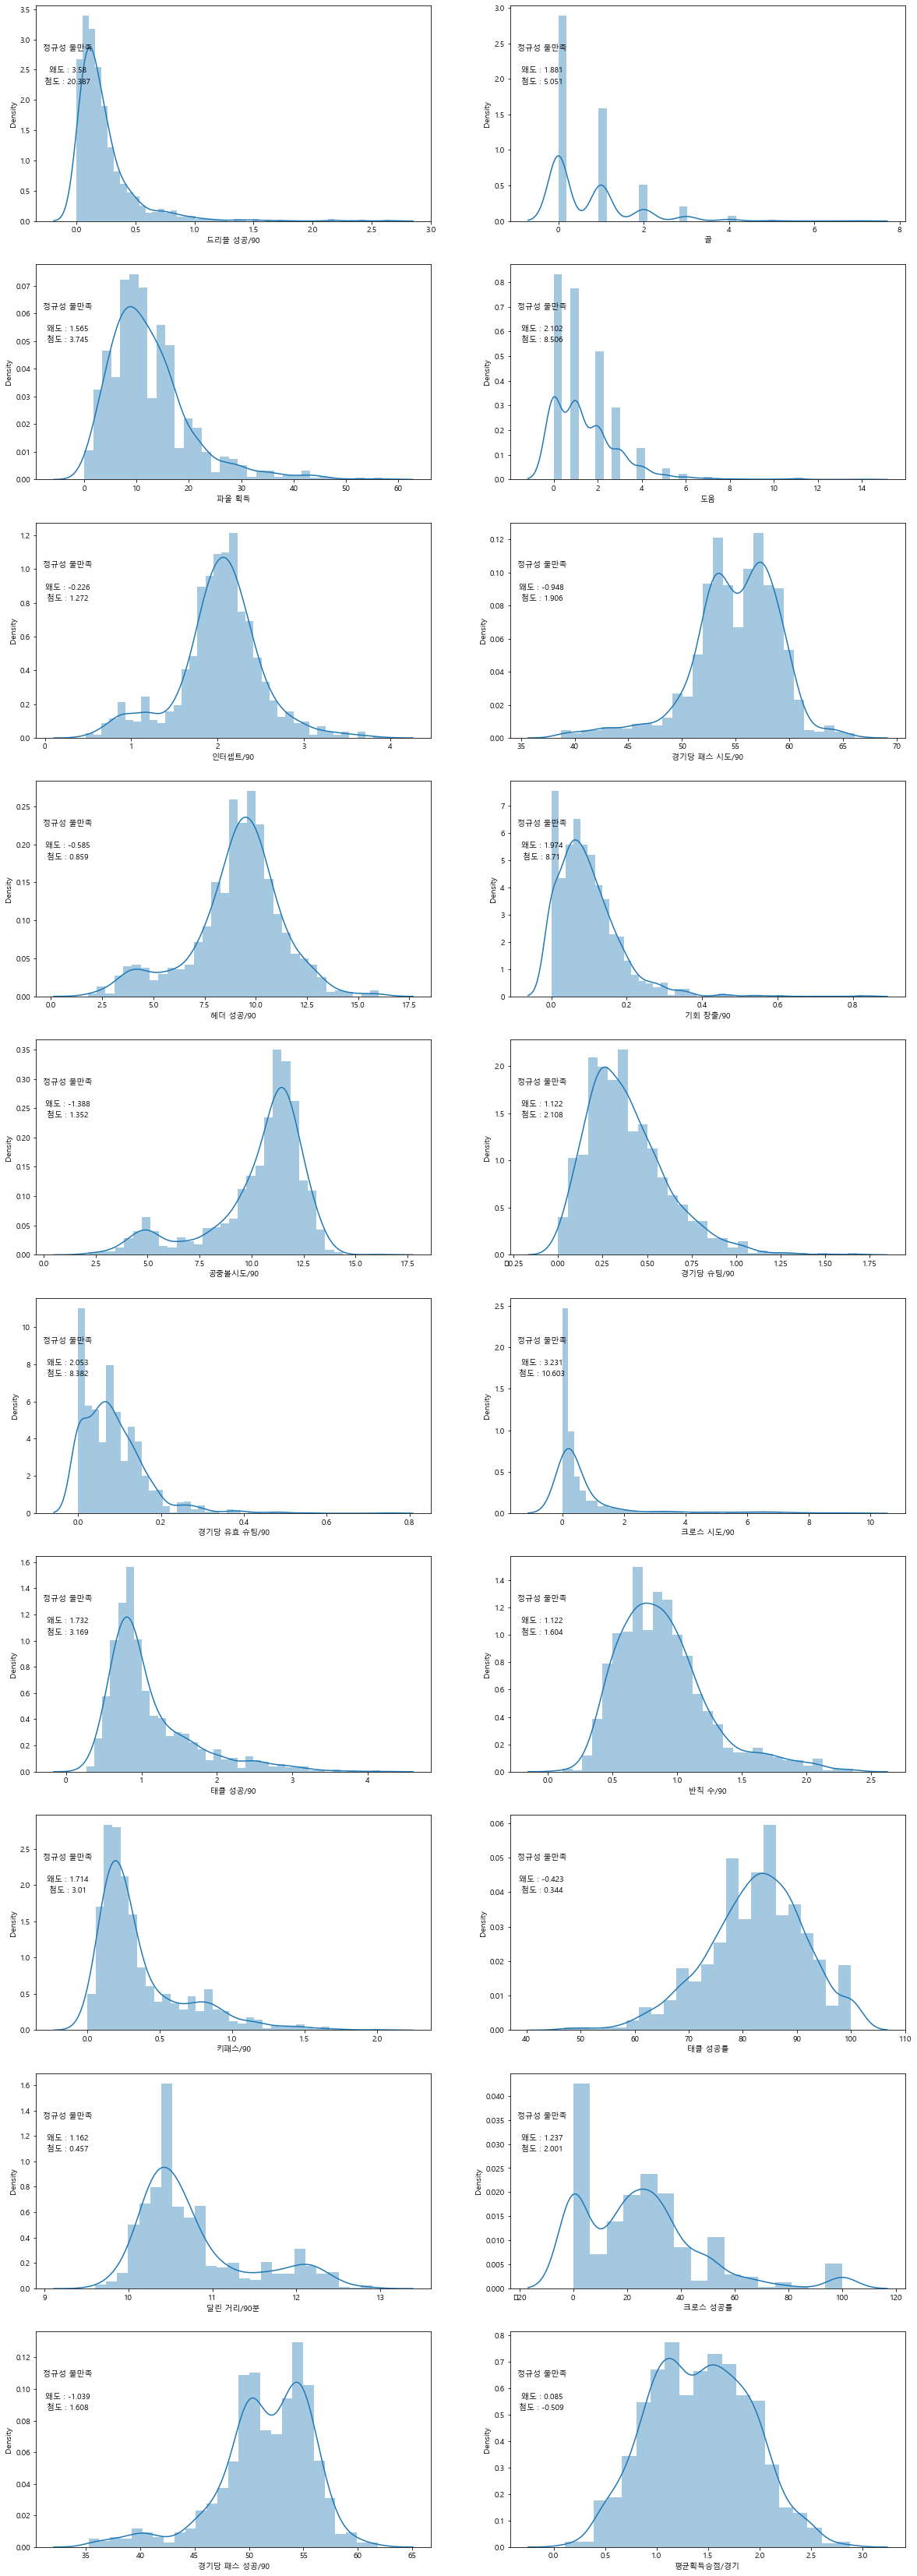

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = defender_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = defender_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

모든 변수가 정규성 불만족 -> 정규화 필요

## 이상치 탐지

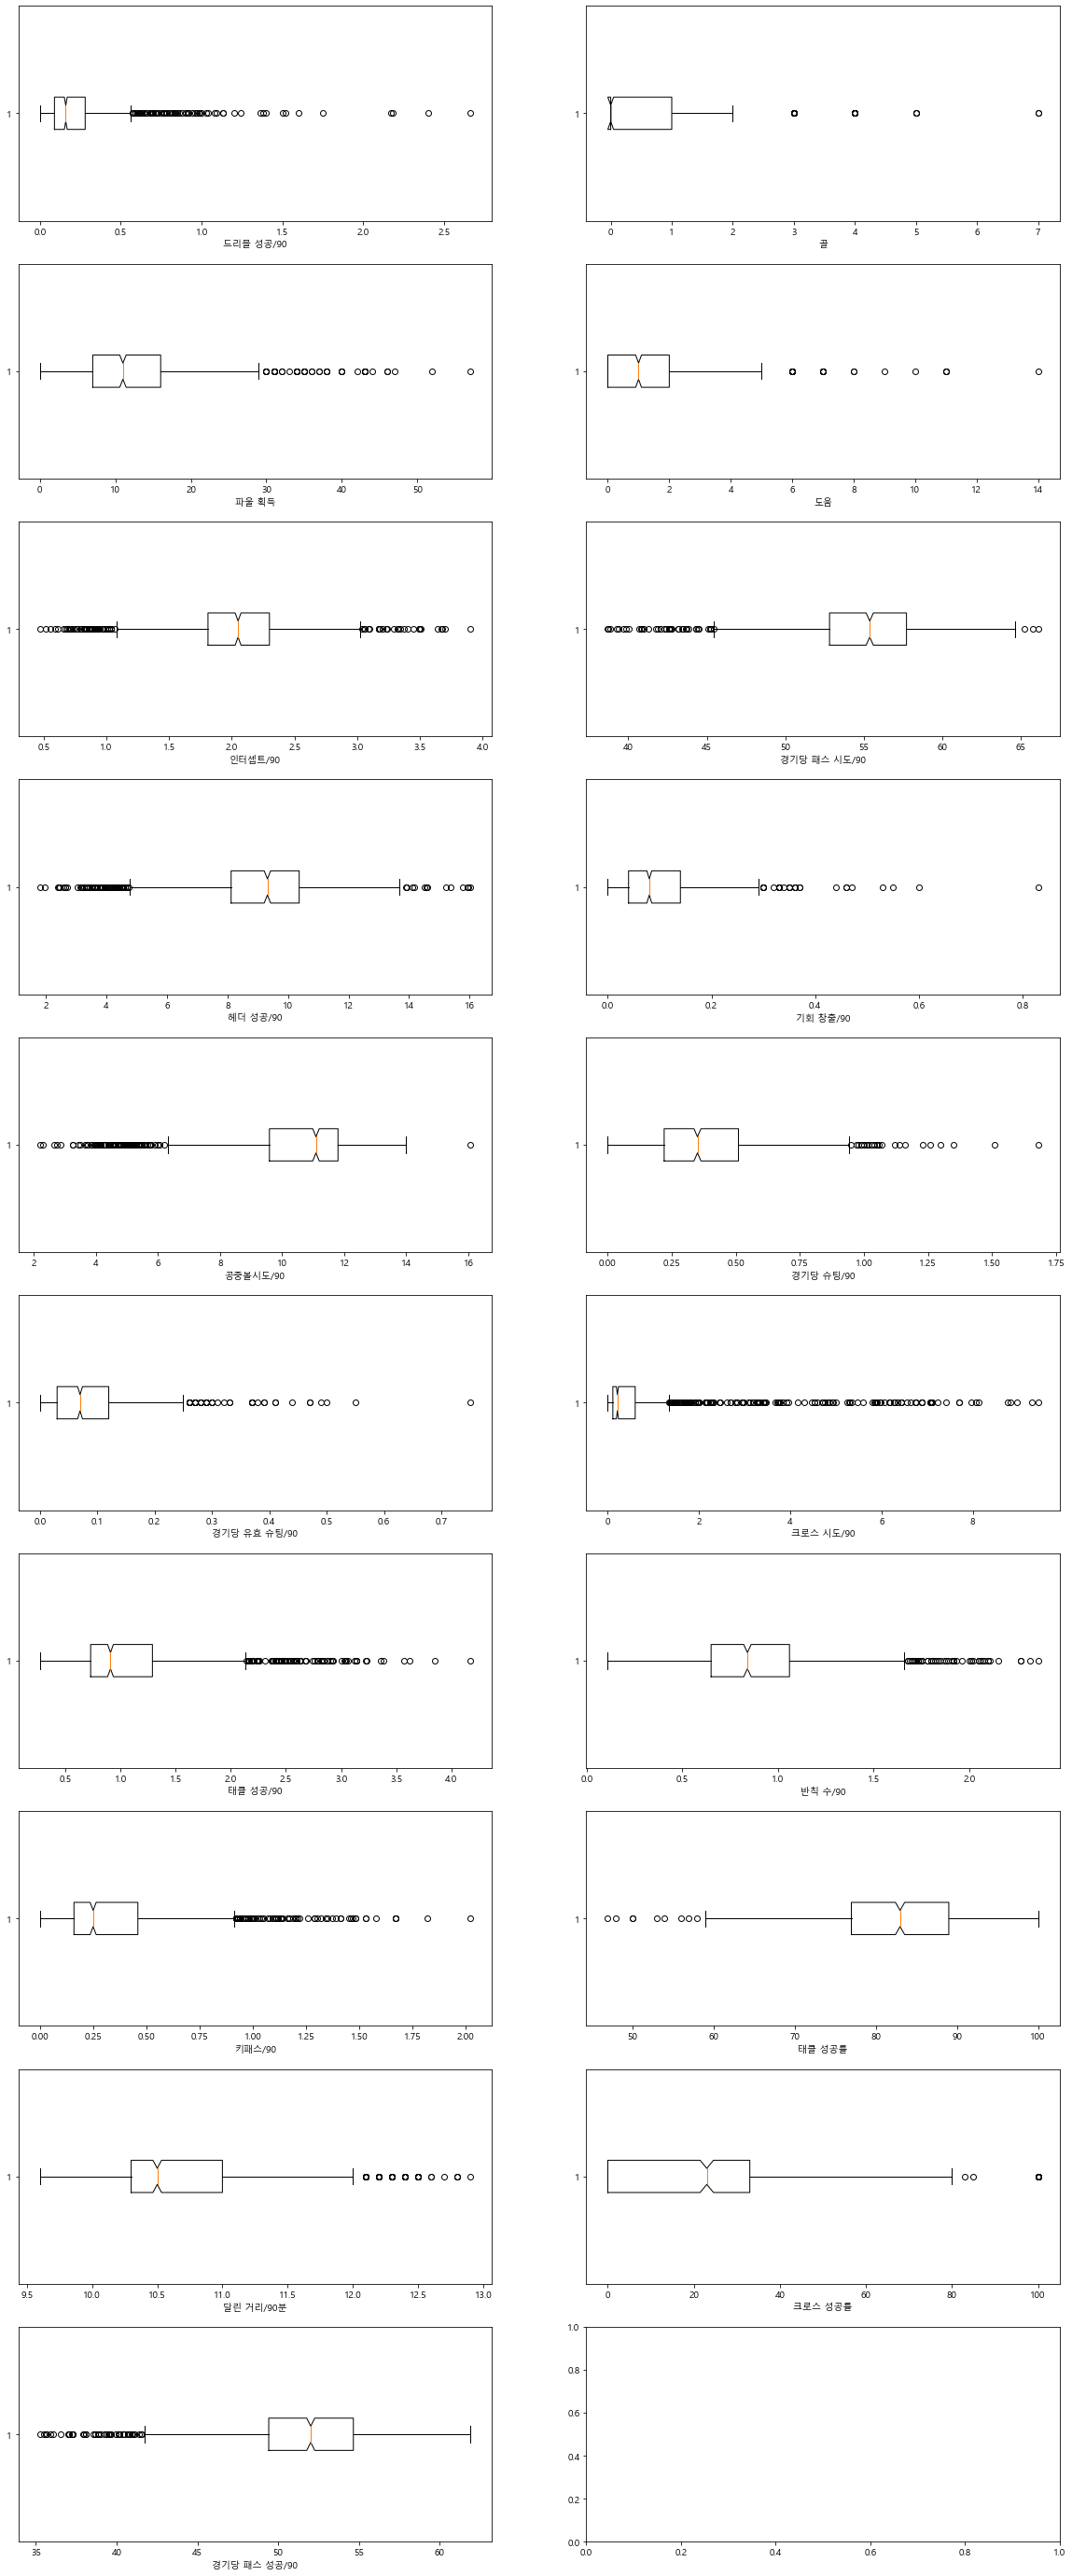

In [6]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value)) :
    ax.set_xlabel(feature)
    ax.boxplot(defender_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [7]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = defender_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/990*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 {len(defender_df)}개의 데이터 중 {len(total)} 개 입니다.')

드리블 성공/90중 이상치는 109개 비율은 약 11.01% 입니다

골중 이상치는 62개 비율은 약 6.263% 입니다

파울 획득중 이상치는 58개 비율은 약 5.859% 입니다

도움중 이상치는 23개 비율은 약 2.323% 입니다

인터셉트/90중 이상치는 128개 비율은 약 12.929% 입니다

경기당 패스 시도/90중 이상치는 51개 비율은 약 5.152% 입니다

헤더 성공/90중 이상치는 105개 비율은 약 10.606% 입니다

기회 창출/90중 이상치는 58개 비율은 약 5.859% 입니다

공중볼시도/90중 이상치는 113개 비율은 약 11.414% 입니다

경기당 슈팅/90중 이상치는 44개 비율은 약 4.444% 입니다

경기당 유효 슈팅/90중 이상치는 56개 비율은 약 5.657% 입니다

크로스 시도/90중 이상치는 190개 비율은 약 19.192% 입니다

태클 성공/90중 이상치는 121개 비율은 약 12.222% 입니다

반칙 수/90중 이상치는 68개 비율은 약 6.869% 입니다

키패스/90중 이상치는 168개 비율은 약 16.97% 입니다

태클 성공률중 이상치는 16개 비율은 약 1.616% 입니다

달린 거리/90분중 이상치는 180개 비율은 약 18.182% 입니다

크로스 성공률중 이상치는 38개 비율은 약 3.838% 입니다

경기당 패스 성공/90중 이상치는 55개 비율은 약 5.556% 입니다

이상치가 있는 row의 갯수는 총 1109개의 데이터 중 455 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인

### 상관계수

#### 상관계수 시각화

<AxesSubplot:>

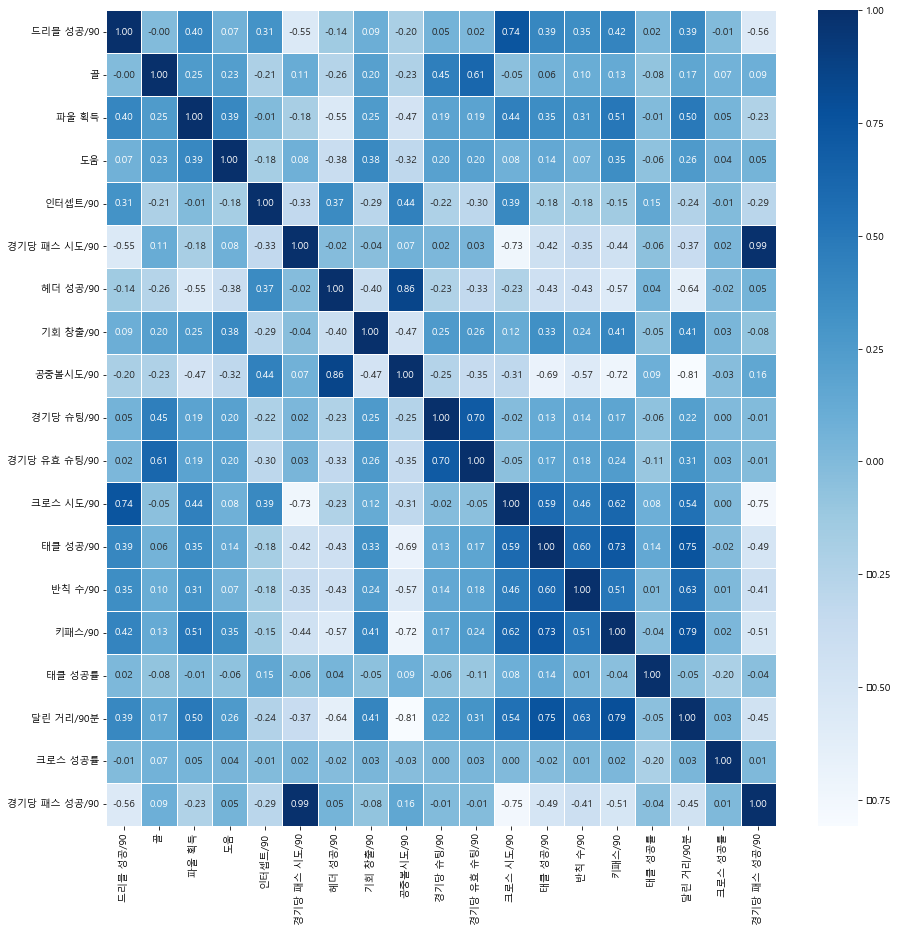

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(data = defender_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

#### 종속변수 간 상관계수 , 독립변수와 상관계수

In [9]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(defender_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,경기당 패스 시도/90,경기당 패스 성공/90,0.984444
1,헤더 성공/90,공중볼시도/90,0.809410


In [10]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(defender_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(corr_list_dependent,columns=['종속변수','독립변수','상관계수'])

,종속변수,독립변수,상관계수
0,드리블 성공/90,평균획득승점/경기,0.104693
1,골,평균획득승점/경기,0.170350
2,파울 획득,평균획득승점/경기,0.042490
3,도움,평균획득승점/경기,0.234076
4,인터셉트/90,평균획득승점/경기,-0.043183
5,경기당 패스 시도/90,평균획득승점/경기,0.294604
6,헤더 성공/90,평균획득승점/경기,-0.050992
7,기회 창출/90,평균획득승점/경기,0.102824
8,공중볼시도/90,평균획득승점/경기,-0.120250
9,경기당 슈팅/90,평균획득승점/경기,0.146920


### 다중공선성

In [11]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(defender_df.loc[:,independent_value].values,i) for i in range(defender_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = defender_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,2.317019,크로스 성공률
1,2.617942,골
2,2.768307,도움
3,3.400982,기회 창출/90
4,4.284752,드리블 성공/90
5,6.140404,경기당 유효 슈팅/90
6,7.016776,파울 획득
7,7.857907,경기당 슈팅/90
8,7.921314,크로스 시도/90
9,10.163174,키패스/90


# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [12]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(defender_df.loc[:,independent_value].values,i) for i in range(defender_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = defender_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [13]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(defender_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 헤더, 공중볼
2. 패스시도, 패스성공
3. 태클성공,태클성공률

### 헤더, 공중볼

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [14]:
defender_df[['헤더 성공/90','공중볼시도/90','평균획득승점/경기']].corr()

,헤더 성공/90,공중볼시도/90,평균획득승점/경기
헤더 성공/90,1.000000,0.855105,-0.033153
공중볼시도/90,0.855105,1.000000,-0.066098
평균획득승점/경기,-0.033153,-0.066098,1.000000


#### 피쳐 엔지니어링

In [15]:
# header accuracy
defender_df['HA'] = (defender_df['헤더 성공/90'] / defender_df['공중볼시도/90'])

independent_value.add('HA')
independent_value = independent_value - set(['헤더 성공/90','공중볼시도/90'])

defender_df[['이름','HA']].sort_values(by='HA',ascending=False).head()

,이름,HA
839,Ali Al Musrati,2.267813
612,Rodri,1.848548
309,Danilo Cataldi,1.805556
99,Daniel Amartey,1.797661
1040,Leander Dendoncker,1.528384


#### 상관계수 확인 (통과)

In [16]:
defender_df[['HA','평균획득승점/경기']].corr()

,HA,평균획득승점/경기
HA,1.000000,0.076855
평균획득승점/경기,0.076855,1.000000


### 패스시도, 패스성공

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균(0.25)보다 높은 피쳐를 만들자)

In [17]:
defender_df[['경기당 패스 성공/90','경기당 패스 시도/90','평균획득승점/경기']].corr()

,경기당 패스 성공/90,경기당 패스 시도/90,평균획득승점/경기
경기당 패스 성공/90,1.000000,0.986422,0.251056
경기당 패스 시도/90,0.986422,1.000000,0.255630
평균획득승점/경기,0.251056,0.255630,1.000000


#### 피쳐 엔지니어링

In [18]:
# Weighted Pass Accuracy 
defender_df['WPA'] = (defender_df['경기당 패스 성공/90'] + defender_df['경기당 패스 시도/90'])

independent_value.add('WPA')
independent_value = independent_value - set(['경기당 패스 시도/90','경기당 패스 성공/90'])

defender_df[['이름','WPA']].sort_values(by='WPA',ascending=False).head()

,이름,WPA
612,Rodri,127.87
970,João Palhinha,127.63
51,Ellyes Skhiri,126.47
288,William Carvalho,124.76
105,Fernando,124.51


#### 상관계수 확인 (통과)

In [19]:
defender_df[['WPA','평균획득승점/경기']].corr()

,WPA,평균획득승점/경기
WPA,1.000000,0.254151
평균획득승점/경기,0.254151,1.000000


#### 다중 공선성 재확인

In [20]:
check_vif(independent_value)

,VIF 계수,종속변수
0,2.310511,크로스 성공률
1,2.620246,골
2,2.766235,도움
3,3.331008,기회 창출/90
4,4.233148,드리블 성공/90
5,6.033089,경기당 유효 슈팅/90
6,6.921504,파울 획득
7,7.851447,경기당 슈팅/90
8,7.851511,크로스 시도/90
9,9.046279,키패스/90


### 태클 성공률, 태클 성공/90

#### 태클 성공률, 태클 성공/90 제거 -> 90분당 태클 시도 생성

In [21]:
defender_df['태클 시도/90'] = defender_df['태클 성공/90']/defender_df['태클 성공률']

In [22]:
defender_df[['태클 시도/90','태클 성공/90','태클 성공률','평균획득승점/경기']].corr()

,태클 시도/90,태클 성공/90,태클 성공률,평균획득승점/경기
태클 시도/90,1.000000,0.976461,-0.048661,0.042643
태클 성공/90,0.976461,1.000000,0.143174,0.027461
태클 성공률,-0.048661,0.143174,1.000000,-0.052896
평균획득승점/경기,0.042643,0.027461,-0.052896,1.000000


In [23]:
defender_df['태클'] = (defender_df['태클 성공/90'])+(defender_df['태클 시도/90'])-defender_df['태클 성공률']
defender_df[['태클','평균획득승점/경기']].corr()

,태클,평균획득승점/경기
태클,1.000000,0.055093
평균획득승점/경기,0.055093,1.000000


In [24]:
independent_value.add('태클 시도/90')
independent_value.add('태클')
independent_value = independent_value-set(['태클 성공률','태클 성공/90' ,'태클 시도/90'])
check_vif(independent_value)

,VIF 계수,종속변수
0,2.309571,크로스 성공률
1,2.620245,골
2,2.764034,도움
3,3.326434,기회 창출/90
4,4.208382,드리블 성공/90
5,6.027560,경기당 유효 슈팅/90
6,6.856398,파울 획득
7,7.276288,크로스 시도/90
8,7.842502,경기당 슈팅/90
9,8.294562,키패스/90


종속변수에 영향이 적은 인터셉트 제거, 크로스 시도 제거를 통해 해결

In [25]:
independent_value = independent_value - set(['크로스 시도/90','인터셉트/90','WPA','달린 거리/90분','반칙 수/90'])

In [26]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수


In [27]:
check_vif(independent_value)

,VIF 계수,종속변수
0,2.196498,크로스 성공률
1,2.441275,드리블 성공/90
2,2.564923,도움
3,2.586184,골
4,3.201708,기회 창출/90
5,4.467392,키패스/90
6,5.689144,경기당 유효 슈팅/90
7,6.057488,파울 획득
8,7.833058,경기당 슈팅/90
9,31.375153,태클


### 파울 획득, 반칙 수

상관계수가 0.7 보다 높고 VIF가 10보다 높기 떄문에 기준에 벗어나지만 모델생성후 변수에 대해 다시 고려하기로 함

### 달린 거리/90

VIF가 너무 높기 때문에 삭제결정

In [28]:
independent_value= independent_value - set(['달린 거리/90분'])

### 최종 종속변수

In [29]:
independent_value

{'HA',
 '경기당 슈팅/90',
 '경기당 유효 슈팅/90',
 '골',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '크로스 성공률',
 '키패스/90',
 '태클',
 '파울 획득'}

In [30]:
defender_df.columns

Index(['이름', '포지션', '골', '도움', '경기당 팀 득점/90', '경기당 팀 실점/90', '크로스 성공률',
       '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90', '평균획득승점/경기',
       '시즌', 'HA', 'WPA', '태클 시도/90', '태클'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

### 독립변수,종속변수 정규화

In [31]:
# 데이터의 2/3 수준의 quantile 적용

defender_qt = QuantileTransformer(n_quantiles=500).fit(defender_df.loc[:,independent_value])
defender_df.loc[:,independent_value] = defender_qt.transform(defender_df.loc[:,independent_value])

In [32]:
independent_value

{'HA',
 '경기당 슈팅/90',
 '경기당 유효 슈팅/90',
 '골',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '크로스 성공률',
 '키패스/90',
 '태클',
 '파울 획득'}

In [33]:
fx_train,fx_test,fy_train,fy_test = train_test_split(defender_df.loc[:,independent_value],defender_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [34]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(32,activation='relu',kernel_regularizer=L2(l2=0.02))(inputs_layer)
hidden2 = Dense(16,activation='relu',kernel_regularizer=L2(l2=0.02))(hidden1)
hidden3 = Dense(8,activation='relu')(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(fx_train,fy_train,batch_size=70,epochs=500,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
mae

Epoch 1/500
13/13 [==============================] - 4s 14ms/step - loss: 2.0459 - val_loss: 1.6159
Epoch 2/500
13/13 [==============================] - 0s 4ms/step - loss: 1.3119 - val_loss: 1.0254
Epoch 3/500
13/13 [==============================] - 0s 4ms/step - loss: 0.9867 - val_loss: 0.9439
Epoch 4/500
13/13 [==============================] - 0s 4ms/step - loss: 0.9498 - val_loss: 0.8844
Epoch 5/500
13/13 [==============================] - 0s 4ms/step - loss: 0.8957 - val_loss: 0.8545
Epoch 6/500
13/13 [==============================] - 0s 4ms/step - loss: 0.8590 - val_loss: 0.8152
Epoch 7/500
13/13 [==============================] - 0s 4ms/step - loss: 0.8208 - val_loss: 0.7833
Epoch 8/500
13/13 [==============================] - 0s 4ms/step - loss: 0.7863 - val_loss: 0.7524
Epoch 9/500
13/13 [==============================] - 0s 4ms/step - loss: 0.7555 - val_loss: 0.7228
Epoch 10/500
13/13 [==============================] - 0s 4ms/step - loss: 0.7249 - val_loss: 0.6953
Epoch 11

13/13 [==============================] - 0s 5ms/step - loss: 0.2350 - val_loss: 0.2377
Epoch 84/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2340 - val_loss: 0.2349
Epoch 85/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2331 - val_loss: 0.2368
Epoch 86/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2335 - val_loss: 0.2337
Epoch 87/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2324 - val_loss: 0.2348
Epoch 88/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2324 - val_loss: 0.2326
Epoch 89/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2316 - val_loss: 0.2347
Epoch 90/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2309 - val_loss: 0.2315
Epoch 91/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2325 - val_loss: 0.2307
Epoch 92/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2300 - val_loss: 0.2313
Epoch 93/500


13/13 [==============================] - 0s 5ms/step - loss: 0.2186 - val_loss: 0.2176
Epoch 246/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2145 - val_loss: 0.2170
Epoch 247/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2123 - val_loss: 0.2208
Epoch 248/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2130 - val_loss: 0.2170
Epoch 249/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2124 - val_loss: 0.2200
Epoch 250/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2164 - val_loss: 0.2182
Epoch 251/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2165 - val_loss: 0.2186
Epoch 252/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2141 - val_loss: 0.2181
Epoch 253/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2120 - val_loss: 0.2180
Epoch 254/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2144 - val_loss: 0.2170
Epoc

13/13 [==============================] - 0s 5ms/step - loss: 0.2069 - val_loss: 0.2185
Epoch 408/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2071 - val_loss: 0.2230
Epoch 409/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2069 - val_loss: 0.2181
Epoch 410/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2066 - val_loss: 0.2174
Epoch 411/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2065 - val_loss: 0.2176
Epoch 412/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2053 - val_loss: 0.2202
Epoch 413/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2061 - val_loss: 0.2233
Epoch 414/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2052 - val_loss: 0.2189
Epoch 415/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2064 - val_loss: 0.2198
Epoch 416/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2052 - val_loss: 0.2180
Epoc

0.3679234812173757

## 변수선택법

In [35]:
from statsmodels.regression.linear_model import OLS

ols_model = OLS(fy_train,fx_train)
regr = ols_model.fit()
best_aic = regr.aic
best_aic

1365.659947820057

In [36]:
best_values = []

for i in range(len(independent_value)+1,1,-1):
    for var in list(combinations(independent_value,i)):
        ols_model = OLS(fy_train,fx_train.loc[:,var])
        regr = ols_model.fit()
        if best_aic<regr.aic:
            pass
        else:
            best_aic = regr.aic
            best_values = var
best_values

('드리블 성공/90',
 '골',
 '키패스/90',
 '파울 획득',
 'HA',
 '도움',
 '경기당 슈팅/90',
 '태클',
 '크로스 성공률',
 '기회 창출/90')

In [37]:
best_aic

1363.8754461119167

In [38]:
independent_value = best_values

In [39]:
fx_train,fx_test,fy_train,fy_test = train_test_split(defender_df.loc[:,independent_value],defender_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [40]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(32,activation='relu',kernel_regularizer=L2(l2=0.02))(inputs_layer)
hidden2 = Dense(16,activation='relu',kernel_regularizer=L2(l2=0.02))(hidden1)
hidden3 = Dense(8,activation='relu')(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(fx_train,fy_train,batch_size=70,epochs=500,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
mae

Epoch 1/500
13/13 [==============================] - 1s 13ms/step - loss: 1.5831 - val_loss: 1.2109
Epoch 2/500
13/13 [==============================] - 0s 6ms/step - loss: 1.0335 - val_loss: 0.9308
Epoch 3/500
13/13 [==============================] - 0s 6ms/step - loss: 0.9251 - val_loss: 0.8889
Epoch 4/500
13/13 [==============================] - 0s 6ms/step - loss: 0.8654 - val_loss: 0.8321
Epoch 5/500
13/13 [==============================] - 0s 6ms/step - loss: 0.8162 - val_loss: 0.7903
Epoch 6/500
13/13 [==============================] - 0s 5ms/step - loss: 0.7724 - val_loss: 0.7482
Epoch 7/500
13/13 [==============================] - 0s 6ms/step - loss: 0.7353 - val_loss: 0.7125
Epoch 8/500
13/13 [==============================] - 0s 7ms/step - loss: 0.7004 - val_loss: 0.6795
Epoch 9/500
13/13 [==============================] - 0s 6ms/step - loss: 0.6674 - val_loss: 0.6481
Epoch 10/500
13/13 [==============================] - 0s 6ms/step - loss: 0.6364 - val_loss: 0.6183
Epoch 11

13/13 [==============================] - 0s 5ms/step - loss: 0.2331 - val_loss: 0.2335
Epoch 84/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2325 - val_loss: 0.2334
Epoch 85/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2317 - val_loss: 0.2330
Epoch 86/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2312 - val_loss: 0.2317
Epoch 87/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2308 - val_loss: 0.2327
Epoch 88/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2302 - val_loss: 0.2309
Epoch 89/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2294 - val_loss: 0.2324
Epoch 90/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2298 - val_loss: 0.2303
Epoch 91/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2286 - val_loss: 0.2299
Epoch 92/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2283 - val_loss: 0.2294
Epoch 93/500


13/13 [==============================] - 0s 5ms/step - loss: 0.2156 - val_loss: 0.2158
Epoch 246/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2149 - val_loss: 0.2172
Epoch 247/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2158 - val_loss: 0.2164
Epoch 248/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2156 - val_loss: 0.2157
Epoch 249/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2160 - val_loss: 0.2164
Epoch 250/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2154 - val_loss: 0.2160
Epoch 251/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2159 - val_loss: 0.2171
Epoch 252/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2158 - val_loss: 0.2160
Epoch 253/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2163 - val_loss: 0.2187
Epoch 254/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2172 - val_loss: 0.2170
Epoc

13/13 [==============================] - 0s 5ms/step - loss: 0.2127 - val_loss: 0.2154
Epoch 408/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2134 - val_loss: 0.2158
Epoch 409/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2132 - val_loss: 0.2184
Epoch 410/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2142 - val_loss: 0.2154
Epoch 411/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2123 - val_loss: 0.2164
Epoch 412/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2121 - val_loss: 0.2154
Epoch 413/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2126 - val_loss: 0.2158
Epoch 414/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2123 - val_loss: 0.2153
Epoch 415/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2134 - val_loss: 0.2153
Epoch 416/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2132 - val_loss: 0.2163
Epoc

0.36815883372281044

In [41]:
with open('./models/defender_qt.pickle','wb') as f:
    pickle.dump(defender_qt,f)
model.save('./models/defender_nn.h5')

# 모델검정

In [42]:
defender_df['predict'] = model.predict(defender_df.loc[:,independent_value])

In [43]:
residual = defender_df['평균획득승점/경기'] - defender_df['predict']

## 선형성 검정

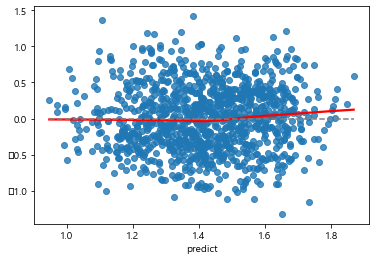

In [44]:
sns.regplot(defender_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([defender_df['predict'].values.min(), defender_df['predict'].values.max()], [0, 0], '--', color='grey')

## 잔차의 정규성 검정

In [45]:
# 정규성 만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9975438714027405, pvalue=0.09295842051506042)

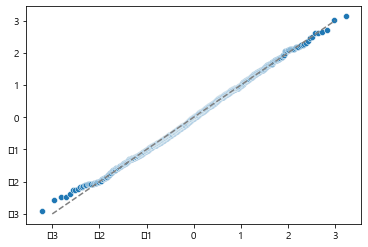

In [46]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 잔차의 등분산성 검정

<AxesSubplot:xlabel='predict'>

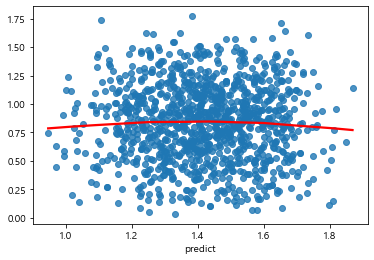

In [47]:
sns.regplot(defender_df['predict'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [48]:
# 등분산성 불만족
stats.levene(defender_df['평균획득승점/경기'],defender_df['predict'])

LeveneResult(statistic=943.8004452626226, pvalue=5.746829455384785e-173)